<a href="https://colab.research.google.com/github/WittyTheMighty/ML-kaggle/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Final Kaggle competition ML

In [2]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import torch as torch
import torchvision as  tv
import torch.nn as nn
import torchvision.transforms as transforms
import os
import pandas as pd
import pickle as pkl
from matplotlib import cm
from PIL import Image
import torch.optim as optim
import torch.nn as nn 
import torch.nn.functional as F 
import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import csv

In [3]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

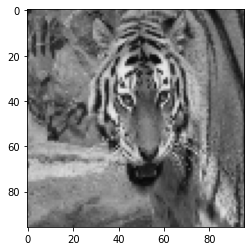

In [4]:
#PATH = './drive/MyDrive/ML-Kaggle/'
PATH = '../data/'

x_train_scalar = np.array(pkl.load(open(PATH+'x_train.pkl', 'rb')))
y_train = np.array(pkl.load(open(PATH+'y_train.pkl', 'rb')))
x_test =  np.array(pkl.load(open(PATH+'x_test.pkl', 'rb')))

x_train = []

for image in x_train_scalar:
    imge_out = Image.fromarray(image.astype('uint8'))
    img_as_img = imge_out.convert("RGB")
    x_train.append(np.array(img_as_img))
    
x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))

plt.imshow(np.transpose(x_train[0], (1, 2 , 0)))

In [5]:
labels = np.unique(y_train)
labels = dict(zip(labels, range(len(labels))))
labels

{'big_cats': 0,
 'butterfly': 1,
 'cat': 2,
 'chicken': 3,
 'cow': 4,
 'dog': 5,
 'elephant': 6,
 'goat': 7,
 'horse': 8,
 'spider': 9,
 'squirrel': 10}

---

## Hyperparameters

In [6]:
batch_size = 64
num_epochs = 20

#pooling
pooling_filter_size = 2
pooling_stride = 2

#k-fold-validation
k_folds = 5

---

## Preprocessing

---
## Model

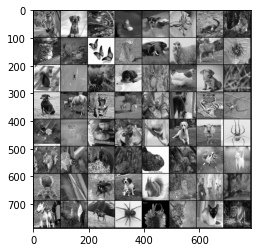

In [7]:
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cuda')
#device = torch.device("cpu")

from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.utils as vutils

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms."""
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]
        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)
    

y_train = [labels[y] for y in y_train]
#x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0, random_state=4)

x_train_tensor = torch.tensor(x_train, dtype=float)
y_train_tensor = torch.tensor(y_train, dtype=float)

trans = transforms.Compose(
    [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
train_dataset = CustomTensorDataset(tensors=(x_train_tensor, y_train_tensor), transform=trans)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=False)

#x_train_tensor.shape
real_batch = next(iter(train_dataloader))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [8]:
conv1 = nn.Conv2d(3,6,5)
pool = nn.MaxPool2d(pooling_filter_size, pooling_stride)
conv2 = nn.Conv2d(6,16,5)
images = real_batch[0].float()
print("images")
print(images.shape)
print("")

x = conv1(images)
print("CONV1")
print(x.shape)
print("")

x = pool(x)
print("POOL1")
print(x.shape)
print("")

x = conv2(x)
print("CONV2")
print(x.shape)
print("")

x = pool(x)
print("POOL2")
print(x.shape)
print("")

images
torch.Size([64, 3, 96, 96])

CONV1
torch.Size([64, 6, 92, 92])

POOL1
torch.Size([64, 6, 46, 46])

CONV2
torch.Size([64, 16, 42, 42])

POOL2
torch.Size([64, 16, 21, 21])



In [9]:
class Net(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        # we use the maxpool multiple times, but define it once
        self.pool = nn.MaxPool2d(pooling_filter_size, pooling_stride)
        # in_channels = 6 because self.conv1 output 6 channel
        self.conv2 = nn.Conv2d(6,16,5) 
        # 5*5 comes from the dimension of the last convnet layer
        self.fc1 = nn.Linear(16*21*21, 240) 
        self.fc2 = nn.Linear(240, 120)
        self.fc3 = nn.Linear(120, 60)
        self.fc4 = nn.Linear(60, 11)
        
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*21*21)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # no activation on final layer 
        return x

net = Net().to(device)

In [10]:
conv1 = nn.Conv2d(3,6,3)
pool = nn.MaxPool2d(pooling_filter_size, pooling_stride)
conv2 = nn.Conv2d(6,16,5)
conv3 = nn.Conv2d(16,26,7)
images = real_batch[0].float()
print("images")
print(images.shape)
print("")

x = conv1(images)
print("CONV1")
print(x.shape)

x = pool(x)
print("POOL1")
print(x.shape)
print("")

x = conv2(x)
print("CONV2")
print(x.shape)

x = pool(x)
print("POOL2")
print(x.shape)
print("")

x = conv3(x)
print("CONV3")
print(x.shape)

x = pool(x)
print("POOL2")
print(x.shape)
print("")

images
torch.Size([64, 3, 96, 96])

CONV1
torch.Size([64, 6, 94, 94])
POOL1
torch.Size([64, 6, 47, 47])

CONV2
torch.Size([64, 16, 43, 43])
POOL2
torch.Size([64, 16, 21, 21])

CONV3
torch.Size([64, 26, 15, 15])
POOL2
torch.Size([64, 26, 7, 7])



In [11]:
class Net(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3)
        # we use the maxpool multiple times, but define it once
        self.pool = nn.MaxPool2d(pooling_filter_size, pooling_stride)
        # in_channels = 6 because self.conv1 output 6 channel
        self.conv2 = nn.Conv2d(6,16,5)
        self.conv3 = nn.Conv2d(16,26,7)
        # 5*5 comes from the dimension of the last convnet layer
        self.fc1 = nn.Linear(26*7*7, 240) 
        self.fc2 = nn.Linear(240, 120)
        self.fc3 = nn.Linear(120, 60)
        self.fc4 = nn.Linear(60, 11)
        
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 26*7*7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # no activation on final layer 
        return x

net = Net().to(device)

In [19]:
# For fold results
results = {}

# Set fixed random number seed
torch.manual_seed(42)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

running_loss = 0 
printfreq = 25

for fold, (train_ids, test_ids) in enumerate(kfold.split(train_dataset)):
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      train_dataset, 
                      batch_size=batch_size, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      train_dataset,
                      batch_size=batch_size, sampler=test_subsampler)
    
    network = Net().to(device)
    network.apply(reset_weights)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(network.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(num_epochs):
        # Print epoch
        print(f'Starting epoch {epoch+1}')

        # Set current loss value
        current_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()
            optimizer.zero_grad()
            outputs = network(inputs)  # forward pass 
            outputs = outputs.float()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            current_loss += loss.item()
            if i % printfreq == printfreq - 1 :
                print('Loss after mini-batch %5d: %.3f' % (i + 1, current_loss / printfreq))
                current_loss = 0.0
         # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')
    
    # Saving the model
    save_path = f'./model-fold-{fold}.pth'
    torch.save(network.state_dict(), save_path)
    
    # Evaluationfor this fold
    correct, total = 0, 0
    with torch.no_grad():

      # Iterate over the test data and generate predictions
      for i, data in enumerate(testloader, 0):

        # Get inputs
        inputs, targets = data
        
        inputs = inputs.float().to(device)
        targets = targets.to(device)

        # Generate outputs
        outputs = network(inputs)

        # Set total and correct
        _, predicted = torch.max(outputs.data, 1)
        
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

      # Print accuracy
      print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
      print('--------------------------------')
      results[fold] = 100.0 * (correct / total)

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average: {sum/len(results.items())} %')

FOLD 0
--------------------------------
Reset trainable parameters of layer = Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(16, 26, kernel_size=(7, 7), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=1274, out_features=240, bias=True)
Reset trainable parameters of layer = Linear(in_features=240, out_features=120, bias=True)
Reset trainable parameters of layer = Linear(in_features=120, out_features=60, bias=True)
Reset trainable parameters of layer = Linear(in_features=60, out_features=11, bias=True)
Starting epoch 1
Loss after mini-batch    25: 2.325
Loss after mini-batch    50: 2.286
Loss after mini-batch    75: 2.204
Loss after mini-batch   100: 2.117
Loss after mini-batch   125: 2.120
Starting epoch 2
Loss after mini-batch    25: 2.057
Loss after mini-batch    50: 2.040
Loss after mini-batch    75: 1.997
Loss after mini-batch  

Loss after mini-batch    25: 0.719
Loss after mini-batch    50: 0.644
Loss after mini-batch    75: 0.737
Loss after mini-batch   100: 0.710
Loss after mini-batch   125: 0.836
Starting epoch 17
Loss after mini-batch    25: 0.604
Loss after mini-batch    50: 0.588
Loss after mini-batch    75: 0.577
Loss after mini-batch   100: 0.642
Loss after mini-batch   125: 0.700
Starting epoch 18
Loss after mini-batch    25: 0.548
Loss after mini-batch    50: 0.457
Loss after mini-batch    75: 0.565
Loss after mini-batch   100: 0.571
Loss after mini-batch   125: 0.619
Starting epoch 19
Loss after mini-batch    25: 0.597
Loss after mini-batch    50: 0.548
Loss after mini-batch    75: 0.462
Loss after mini-batch   100: 0.622
Loss after mini-batch   125: 0.560
Starting epoch 20
Loss after mini-batch    25: 0.356
Loss after mini-batch    50: 0.391
Loss after mini-batch    75: 0.380
Loss after mini-batch   100: 0.411
Loss after mini-batch   125: 0.413
Training process has finished. Saving trained model.


Loss after mini-batch    75: 1.149
Loss after mini-batch   100: 1.230
Loss after mini-batch   125: 1.374
Starting epoch 11
Loss after mini-batch    25: 1.082
Loss after mini-batch    50: 1.152
Loss after mini-batch    75: 1.133
Loss after mini-batch   100: 1.108
Loss after mini-batch   125: 1.146
Starting epoch 12
Loss after mini-batch    25: 0.992
Loss after mini-batch    50: 1.010
Loss after mini-batch    75: 0.979
Loss after mini-batch   100: 1.010
Loss after mini-batch   125: 1.080
Starting epoch 13
Loss after mini-batch    25: 0.918
Loss after mini-batch    50: 0.989
Loss after mini-batch    75: 0.915
Loss after mini-batch   100: 1.014
Loss after mini-batch   125: 0.902
Starting epoch 14
Loss after mini-batch    25: 0.798
Loss after mini-batch    50: 0.753
Loss after mini-batch    75: 0.860
Loss after mini-batch   100: 0.932
Loss after mini-batch   125: 0.832
Starting epoch 15
Loss after mini-batch    25: 0.592
Loss after mini-batch    50: 0.623
Loss after mini-batch    75: 0.735


In [13]:
network = Net()
network.load_state_dict(torch.load('./model-fold-2.pth'))
network.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 26, kernel_size=(7, 7), stride=(1, 1))
  (fc1): Linear(in_features=1274, out_features=240, bias=True)
  (fc2): Linear(in_features=240, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=60, bias=True)
  (fc4): Linear(in_features=60, out_features=11, bias=True)
)

In [15]:
x_test_tensor = torch.tensor(x_test, dtype=float)
y_test_tensor = torch.tensor(y_test, dtype=float)

test_dataset = CustomTensorDataset(tensors=(x_test_tensor, y_test_tensor), transform=trans)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

NameError: name 'y_test' is not defined

In [16]:
numberOfBatches = 0
totalAccuracy = 0

for i, data in enumerate(test_dataloader):
    numberOfBatches += 1
    inputs, labels = data
    
    outputs = network(inputs.float())
    
    print(outputs.shape)

    preds = outputs.argmax(dim=1).cpu()
    
    print(preds.shape)
    print(preds)
    print(labels.shape)
    print(labels)
    print("")

    totalAccuracy += accuracy_score(labels.cpu(), preds.cpu())

print(totalAccuracy / numberOfBatches)

NameError: name 'test_dataloader' is not defined

In [17]:
def make_submission(x_test, network):
    header = ["Id", "class"]
    id_value = 0
    
    classifications =[]
    for image in tqdm.tqdm(x_test):
        image = torch.reshape(image, (1, 3, 96, 96))
        classifications.append([id_value, network(image.float()).argmax(dim=1)[0].item()])
        id_value += 1
    
    y = "./submission.csv"
    with open(y, 'w', newline='') as work:
        z = csv.writer(work)
        z.writerow(header)
        z.writerows(classifications)

In [18]:
x_test_scalar =  np.array(pkl.load(open(PATH+'x_test.pkl', 'rb')))

x_test = []

for image in x_test_scalar:
    imge_out = Image.fromarray(image.astype('uint8'))
    img_as_img = imge_out.convert("RGB")
    x_test.append(np.array(img_as_img))
    

x_test = np.transpose(np.array(x_test), (0, 3, 1, 2))

x_test = torch.tensor(x_test, dtype=float)

network = Net()
network.load_state_dict(torch.load('./model-fold-2.pth'))
network.eval()

make_submission(x_test, network)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17831/17831 [00:14<00:00, 1213.18it/s]
